## Midterm project: Equity Portfolio Management

### Author : Ritikaa Kailas

### Data Preparation

Download the historial daily data of the entire 2018 for the 10 stocks 

```python
universe = ['IBM', 'MSFT', 'GOOG', 'AAPL', 'AMZN', 'FB', 'NFLX', 'TSLA', 'ORCL', 'SAP']
```

For example, to download IBM data, use the following link to go to yahoo finance page. Find the "Download Data" link to download the csv file to you local disk.
https://finance.yahoo.com/quote/IBM/history?period1=1514782800&period2=1546232400&interval=1d&filter=history&frequency=1d

Replace "IBM" with other stock symbol in the above URL, you will be able to download data for other 9 stocks.

You should have 10 csv files on your disk now. IBM.csv, MSFT.csv, etc. We call the 10 stocks "universe" which is the entire stock market you can trade.


![image.png](attachment:image.png)


### Retrieve the "Close" and "Adj Close" values for each stock

You will create a dataframe where there are 20 columns for the 10 stocks, each row is the "Close" and "Adj Close" prices for the 10 stocks on each day, in the order of the business days in 2018. Assume all buy/sell on the "Close" prices and there is no transaction cost.

### You start to manage 5 million dollars fund on Jan 02, 2018

You have a strategy to manage the fund.

1. On Jan 02 2018, you split the \\$5m into 5 \\$1m, and use them to buy 5 stocks from the 10 stocks. For example, IBM close price was \\$154.25. With \\$1m, you can buy max 6482 shares with cost \\$999848.5 with \\$151.5‬ cash left. You decided to spend \\$1m on each of ['IBM', 'MSFT', 'GOOG', 'AAPL', 'AMZN'] respectively and keep the rest cash into a zero-interest cash account. On Jan 02 2018, your mark to market value (MTM) is \\$5m if combining all stocks value and cash. Your holdings of stocks and cach account is your portfolio.

\begin{equation*}
\ MTM^t =  cash^t + \sum_{k=1}^5 Shares_k^t \times ClosePrice_k^t \
\end{equation*}


2. Your trading strategy is "5 days rebalancing of buying low". Here is how it works. You keep your portfolio unchanged until 5 days later on Jan 09 2018. Now you want to re-check the market and adjust your portfolio. You will compute the "Adj Close" price changes from Jan 02 to Jan 09, and find the 5 stocks whose "Adj Close" prices dropped the most in terms of percentage. You sell all current holdings on Jan 09 "Close" prices to convert your portfolio to all cash. Then immediately split your cash, including your cash account, to 5 equal parts to buy the 5 stocks that dropped the most from Jan 02 to Jan 09 on 'Adj Close' prices. You always buy the max shares of stock on the "Close" price and keep the rest cash in cash account. Now the portfolio should be different from 5 days ago. This operation is called "rebalancing".

    Keep in mind, the MTM will change every day, even when your portfolio holdings don't change, because the stock prices change.


3. Corporations generally issue stock dividends on some days. The total dividend you get on such a day is the stock dividend  times your shares if you have shares of this stock on the dividend day. If you buy shares on the dividend day, these bought shares are not qualified to get dividend. If you sell shares on the dividend day, the sold shares are qualified to get dividend. For example, on 2/8/2018, IBM issued \$1.5 dividend per share. In your cash account, you will automatically get

\begin{equation*}
\$1.5 \times \left(your\ IBM\ shares\ on\ 2/8/2018\right)
\end{equation*} 



4. 5 business days later on Jan 17 (Jan 15 was a holiday), you re-check the market and adjust your portfolio again. You will have a new portfolio on Jan 17.


5. If you run this strategy every 5 days all the way to Dec 31 2018, you will have a daily MTM. You expect the MTM on Dec 31 2018 should be higher than \$5m because you always buy the stocks that dropped the most, i.e., you always buy low.


6. Another strategy is "5 days rebalancing of buying high". You always buy the 5 stocks whose "Adj Close" prices surge the most in terms of percentage because you believe the trend will continue. Run the new strategy and see how the MTM will change.


7. You will create a "high tech index" which is simply the daily average of the 10 stocks "Close" prices. Compare your MTM series with the "high tech index" and plot their curves. To plot the two curves together, you may want to convert the series to daily percentage change with regard to Jan 02 2018.


8. Download the USD/JPY 2018 historical data at https://www.myfxbook.com/en/forex-market/currencies/USDJPY-historical-data then use the "Close" column as the rate to convert your MTM series from USD to JPY. Plot the two MTM curves. You will need to convert to daily percentage change too.


9. The above two strategies both rebalance every 5 days. Try to change the days interval and find the optimal days interval that maximizes the MTM on 12/31/2018. 

### Submit

* This project must be in R.

* This is a group project. Your group can have up to 4 members. 

*<!--  Submit your jupyter notebook file in both HTML format and ipynb format with all intermediate results and the final dataframe. Plot the curves. Each member will need to submit a copy on canvas.

* Due in 3 week from today. -->





### Pre-requisite 

In [1]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(reshape2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




### Data preperation

In [2]:
folder_path = "/Users/ritikaakailas/Desktop/Data_Analytics_Midterm/"
stocks = c('IBM', 'MSFT', 'GOOG', 'AAPL', 'AMZN', 'META', 'NFLX', 'TSLA', 'ORCL', 'SAP')
usd_jpy = read.csv("/Users/ritikaakailas/Desktop/Data_Analytics_Midterm/usdjpy.csv", fileEncoding = "latin1", stringsAsFactors = FALSE)
usd_jpy$Date = as.Date(usd_jpy$Date, format = "%d-%b-%y")
stock_files = tolower(stocks)

### Retriving the "Close" and "Adj Close" values for each stock and storing it into universe

In [3]:
stock_data_list = list() #initialize a list to store all the stock data

#Initially we store the entire stock data into stock_data and the refine it to only the close and Adj close colums of each stock
for (i in seq_along(stocks)) {
    stock = stocks[i]
    file_name = paste0(stock_files[i], ".csv")
    file_path = paste0(folder_path, file_name)
    stock_data = read.csv(file_path)

    stock_data$Date = as.Date(stock_data$Date, format = "%d-%b-%y")
    
    if (!"Dividends" %in% colnames(stock_data)) {
        stock_data$Dividends = 0
    }
    
    stock_data = stock_data %>%
        select(Date, Close, Adj.Close, Dividends) %>%
        rename(!!paste0(stock, ".Close") := Close, !!paste0(stock, ".Adj.Close") := Adj.Close, !!paste0(stock, ".Dividends") := Dividends)
    
    # Store the data in the list
    stock_data_list[[stock]] = stock_data
} 

# Merging all stock data into a single dataframe by Date
universe = Reduce(function(x, y) merge(x, y, by = "Date", all = TRUE), stock_data_list)
universe = universe[order(universe$Date), ]

#universe has the close and adj close prices of all the stocks by Date 
head(universe)

,Date,IBM.Close,IBM.Adj.Close,IBM.Dividends,MSFT.Close,MSFT.Adj.Close,MSFT.Dividends,GOOG.Close,GOOG.Adj.Close,GOOG.Dividends,⋯,NFLX.Dividends,TSLA.Close,TSLA.Adj.Close,TSLA.Dividends,ORCL.Close,ORCL.Adj.Close,ORCL.Dividends,SAP.Close,SAP.Adj.Close,SAP.Dividends
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2018-01-02,147.47,107.53,0,85.95,79.79,0,53.25,53.12,0,⋯,0,21.37,21.37,0,46.63,41.87,0,112.39,99.96,0
2,2018-01-03,151.52,110.49,0,86.35,80.16,0,54.12,53.99,0,⋯,0,21.15,21.15,0,47.71,42.84,0,113.31,100.77,0
3,2018-01-04,154.59,112.72,0,87.11,80.87,0,54.32,54.19,0,⋯,0,20.97,20.97,0,48.18,43.26,0,115.05,102.32,0
4,2018-01-05,155.34,113.27,0,88.19,81.87,0,55.11,54.98,0,⋯,0,21.11,21.11,0,48.47,43.52,0,116.33,103.46,0
5,2018-01-08,156.28,113.96,0,88.28,81.96,0,55.35,55.21,0,⋯,0,22.43,22.43,0,48.98,43.98,0,114.80,102.10,0
6,2018-01-09,156.63,114.21,0,88.22,81.90,0,55.31,55.18,0,⋯,0,22.25,22.25,0,49.06,44.22,0,114.16,101.53,0


### Function to calculate MTM and update cash accounts for dividends

In [4]:
# Function to compute MTM and update cash account for dividends
mtm_calculator = function(date, universe, portfolio, cash_account) {
    date_data = universe[universe$Date == as.Date(date), ]
    mtm = cash_account
    total_dividends = 0
    
    for (stock in names(portfolio)) {
        close_price = date_data[[paste0(stock, ".Close")]]
        num_shares = portfolio[[stock]]$shares
        mtm = mtm + (num_shares * close_price)
        
        # Check for dividends
        dividend_per_share = date_data[[paste0(stock, ".Dividends")]]
        if (!is.na(dividend_per_share) && dividend_per_share > 0) {
            dividend_income = num_shares * dividend_per_share
            total_dividends = total_dividends + dividend_income
        }
    }
    
    cash_account = cash_account + total_dividends
    mtm = mtm + total_dividends
    day_mtm = mtm + cash_account
    return(list(mtm = mtm, cash_account = cash_account , day_mtm = day_mtm))
}

options(scipen = 999)

In [5]:
initial_capital = 5000000

stocks = c('IBM', 'MSFT', 'GOOG', 'AAPL', 'AMZN')

initial_allocation = initial_capital / length(stocks) 

# Get the first trading date available 
initial_date = min(universe$Date)
initial_data = universe %>% filter(Date == initial_date)

# Initializing portfolio as a list and variable for cash account
portfolio = list()
cash_account = 0 

# Purchase initial shares
for (stock in stocks) {
    close_price = initial_data[[paste0(stock, ".Close")]]
    num_shares = floor(initial_allocation / close_price)
    total_cost = num_shares * close_price
    remaining_cash = initial_allocation - total_cost
    cash_account = cash_account + remaining_cash 
    portfolio[[stock]] = list(shares = num_shares)
}

print("Initial Portfolio Holdings:")
print(portfolio)
print(paste("Initial Cash Account:", round(cash_account, 2)))


mtm_jan02 = mtm_calculator("2018-01-02", universe, portfolio, cash_account)
print(paste("MTM on Jan 02, 2018:", mtm_jan02$day_mtm))

[1] "Initial Portfolio Holdings:"
$IBM
$IBM$shares
[1] 6781


$MSFT
$MSFT$shares
[1] 11634


$GOOG
$GOOG$shares
[1] 18779


$AAPL
$AAPL$shares
[1] 23223


$AMZN
$AMZN$shares
[1] 16820


[1] "Initial Cash Account: 150.5"
[1] "MTM on Jan 02, 2018: 5000150.5"


### Buying low strategy

In [6]:
# Get data for Jan 02 and Jan 09 i.e the first rebalancing interval
jan02_data = universe %>% filter(Date == as.Date('2018-01-02'))
jan09_data = universe %>% filter(Date == as.Date('2018-01-09'))

#get all the stock data to check the highest drop
adj_close_columns = colnames(universe)[grep('.Adj.Close', colnames(universe))]
stock_names = sub('.Adj.Close', '', adj_close_columns)

#stock_df will have the stock data along with the percentage changes 
stocks_df = data.frame(Stock = stock_names)
stocks_df$Jan02_AdjClose = as.numeric(jan02_data[1, adj_close_columns])
stocks_df$Jan09_AdjClose = as.numeric(jan09_data[1, adj_close_columns])
stocks_df$PercentageChange = (stocks_df$Jan09_AdjClose - stocks_df$Jan02_AdjClose) / stocks_df$Jan02_AdjClose * 100

print("Percentage Change from Jan 02 to Jan 09:")
print(stocks_df)

# pick the top 5 low percentage changed stocks
stocks_df = stocks_df[order(stocks_df$PercentageChange), ]
top5_drops = head(stocks_df, 5)
print("Top 5 Stocks with the Smallest Gains:")
print(top5_drops)

#total cash holds the value of amount after selling stocks and previously remaining cash
total_cash = cash_account

#Rebalance on day 5
for (stock in names(portfolio)) {
    num_shares = portfolio[[stock]]$shares
    close_price = jan09_data[[paste0(stock, '.Close')]]
    cash_from_sale = num_shares * close_price
    total_cash = total_cash + cash_from_sale
}

print(paste("Total Cash after Selling Holdings on Jan 09:i.e (mtm)", round(total_cash, 2)))

# Reset cash account as we have to allocate 
cash_account = 0

#Prepare for next rounds of rebalancing
allocated_cash = total_cash / 5
print(paste("Allocated Cash per Stock:", round(allocated_cash, 2)))

# Initialize new portfolio
portfolio = list()

for (stock in top5_drops$Stock) {
    close_price = jan09_data[[paste0(stock, '.Close')]]
    num_shares = floor(allocated_cash / close_price)
    total_cost = num_shares * close_price
    remaining_cash = allocated_cash - total_cost
    cash_account = cash_account + remaining_cash
    portfolio[[stock]] = list(shares = num_shares)
    print(paste("Purchased", num_shares, "shares of", stock, "at", close_price, "per share, costing", round(total_cost, 2)))
    print(paste("Remaining Cash after purchasing", stock, ":", round(remaining_cash, 2)))
}

print(paste("Updated Cash Account after Rebalancing:", round(cash_account, 2)))

print("New Portfolio Holdings after Rebalancing:")
print(portfolio)
print(paste("Cash Account Balance:", round(cash_account, 2)))

#calculate mtm for day 9
mtm_jan09 = mtm_calculator("2018-01-09", universe, portfolio, cash_account)
print(paste("MTM on Jan 09, 2018:", mtm_jan09$day_mtm))

[1] "Percentage Change from Jan 02 to Jan 09:"
   Stock Jan02_AdjClose Jan09_AdjClose PercentageChange
1    IBM         107.53         114.21         6.212220
2   MSFT          79.79          81.90         2.644442
3   GOOG          53.12          55.18         3.878012
4   AAPL          40.57          41.06         1.207789
5   AMZN          59.45          62.63         5.349033
6   META         180.88         187.31         3.554843
7   NFLX         201.07         209.31         4.098075
8   TSLA          21.37          22.25         4.117922
9   ORCL          41.87          44.22         5.612610
10   SAP          99.96         101.53         1.570628
[1] "Top 5 Stocks with the Smallest Gains:"
   Stock Jan02_AdjClose Jan09_AdjClose PercentageChange
4   AAPL          40.57          41.06         1.207789
10   SAP          99.96         101.53         1.570628
2   MSFT          79.79          81.90         2.644442
6   META         180.88         187.31         3.554843
3   GOOG     

In [7]:
# Now rebalancing starting from Jan 09, 2018

# Get all trading dates from the universe
trading_dates = universe$Date
start_index = which(trading_dates == as.Date('2018-01-09'))

# Generate rebalancing dates starting from Jan 09, 2018
rebalancing_indices = seq(start_index, length(trading_dates), by = 5)
rebalancing_dates = trading_dates[rebalancing_indices]
rebalancing_dates = rebalancing_dates[rebalancing_dates <= as.Date('2018-12-31')]

mtm_values_low = data.frame(Date = trading_dates, MTM = NA)

#Main loop to implement low buying strategy every 5 days
for (current_date in trading_dates) {
    # Compute and store everyday MTM
    mtm_result = mtm_calculator(current_date, universe, portfolio, cash_account)
    mtm_values_low$MTM[mtm_values_low$Date == current_date] = mtm_result$day_mtm
    
    # Check if current_date is a rebalancing date
    if (current_date %in% rebalancing_dates) {
        index_current = which(trading_dates == current_date)
        index_start = index_current - 5
        if (index_start < 1) {
            index_start = 1
        }
        date_5_days_ago = trading_dates[index_start]
        
        # Compute percentage changes in Adj Close prices
        date_start_data = universe %>% filter(Date == date_5_days_ago)
        date_end_data = universe %>% filter(Date == current_date)
        adj_close_columns = colnames(universe)[grep('.Adj.Close', colnames(universe))]
        stock_names = sub('.Adj.Close', '', adj_close_columns)
        
        # Select the top 5 stocks (largest drops or smallest gains) in the rebalancing window
        stocks_df$Start_AdjClose = as.numeric(date_start_data[1, adj_close_columns])
        stocks_df$End_AdjClose = as.numeric(date_end_data[1, adj_close_columns])
        stocks_df$PercentageChange = (stocks_df$End_AdjClose - stocks_df$Start_AdjClose) / stocks_df$Start_AdjClose * 100
        stocks_df = stocks_df[order(stocks_df$PercentageChange), ]
        top5_drops = head(stocks_df, 5)
        
        # Sell all current holdings gor rebalancing day
        total_cash = cash_account
        for (stock in names(portfolio)) {
            num_shares = portfolio[[stock]]$shares
            close_price = date_end_data[[paste0(stock, '.Close')]]
            cash_from_sale = num_shares * close_price
            total_cash = total_cash + cash_from_sale
        }

        cash_account = 0
        
        # buy top 5 dropped stocks 
        allocated_cash = total_cash / 5
        portfolio = list()
        for (stock in top5_drops$Stock) {
            close_price = date_end_data[[paste0(stock, '.Close')]]
            num_shares = floor(allocated_cash / close_price)
            total_cost = num_shares * close_price
            remaining_cash = allocated_cash - total_cost
            cash_account = cash_account + remaining_cash
            portfolio[[stock]] = list(shares = num_shares)
        }
    }
}

# Extract MTM value on December 31, 2018
final_mtm = mtm_values_low$MTM[mtm_values_low$Date == as.Date('2018-12-28')]
print(paste("Final MTM on December 31, 2018:", round(final_mtm, 2)))

[1] "Final MTM on December 31, 2018: 4725228"


### Buying high strategy

In [8]:
# Implementing buying high strategy for Jan 02 and Jan 09 data
jan02_data = universe %>% filter(Date == as.Date('2018-01-02'))
jan09_data = universe %>% filter(Date == as.Date('2018-01-09'))
adj_close_columns = colnames(universe)[grep('.Adj.Close', colnames(universe))]
stock_names = sub('.Adj.Close', '', adj_close_columns)

# Initialize a dataframe to store all stock data along with the percentage changes in the rebalancing interval
stocks_df = data.frame(Stock = stock_names)
stocks_df$Jan02_AdjClose = as.numeric(jan02_data[1, adj_close_columns])
stocks_df$Jan09_AdjClose = as.numeric(jan09_data[1, adj_close_columns])
stocks_df$PercentageChange = (stocks_df$Jan09_AdjClose - stocks_df$Jan02_AdjClose) / stocks_df$Jan02_AdjClose * 100

# Sort stocks by PercentageChange in decreasing order abd pick the top five stocks having the highest gains
stocks_df = stocks_df[order(stocks_df$PercentageChange, decreasing = TRUE), ]
top5_drops = head(stocks_df, 5)

print("Top 5 Stocks with the largest Gains:")
print(top5_drops)

#Selling the stock on rebalancing day
total_cash = cash_account
for (stock in names(portfolio)) {
    num_shares = portfolio[[stock]]$shares
    close_price = jan09_data[[paste0(stock, '.Close')]]
    cash_from_sale = num_shares * close_price
    total_cash = total_cash + cash_from_sale
}
print(paste("Total Cash after Selling Holdings on Jan 09:", round(total_cash, 2)))

# Reset cash account
cash_account <- 0

# Buying stock on rebalancing day by implementing buying high strategy
allocated_cash = total_cash / 5
print(paste("Allocated Cash per Stock:", round(allocated_cash, 2)))
portfolio <- list()
for (stock in top5_drops$Stock) {
    close_price <- jan09_data[[paste0(stock, '.Close')]]
    num_shares <- floor(allocated_cash / close_price)
    total_cost <- num_shares * close_price
    remaining_cash <- allocated_cash - total_cost
    cash_account <- cash_account + remaining_cash
    portfolio[[stock]] <- list(shares = num_shares)
    print(paste("Purchased", num_shares, "shares of", stock, "at", close_price, "per share, costing", round(total_cost, 2)))
    print(paste("Remaining Cash after purchasing", stock, ":", round(remaining_cash, 2)))
}

print(paste("Updated Cash Account after Rebalancing:", round(cash_account, 2)))

print("New Portfolio Holdings after Rebalancing:")
print(portfolio)
print(paste("Cash Account Balance:", round(cash_account, 2)))

[1] "Top 5 Stocks with the largest Gains:"
  Stock Jan02_AdjClose Jan09_AdjClose PercentageChange
1   IBM         107.53         114.21         6.212220
9  ORCL          41.87          44.22         5.612610
5  AMZN          59.45          62.63         5.349033
8  TSLA          21.37          22.25         4.117922
7  NFLX         201.07         209.31         4.098075
[1] "Total Cash after Selling Holdings on Jan 09: 5192771.44"
[1] "Allocated Cash per Stock: 1038554.29"
[1] "Purchased 6630 shares of IBM at 156.63 per share, costing 1038456.9"
[1] "Remaining Cash after purchasing IBM : 97.39"
[1] "Purchased 21169 shares of ORCL at 49.06 per share, costing 1038551.14"
[1] "Remaining Cash after purchasing ORCL : 3.15"
[1] "Purchased 16582 shares of AMZN at 62.63 per share, costing 1038530.66"
[1] "Remaining Cash after purchasing AMZN : 23.63"
[1] "Purchased 46676 shares of TSLA at 22.25 per share, costing 1038541"
[1] "Remaining Cash after purchasing TSLA : 13.29"
[1] "Purchased 4961 s

In [9]:
# Now rebalancing starting from Jan 09, 2018 for buying high strategy

# Get all trading dates from the universe from jan09, 2018
trading_dates = universe$Date
start_index = which(trading_dates == as.Date('2018-01-09'))
if (length(start_index) == 0) {
    stop("Jan 09, 2018, is not in the trading dates.")
}

# Get rebalancing dates starting from Jan 09, 2018
rebalancing_indices = seq(start_index, length(trading_dates), by = 5)
rebalancing_dates = trading_dates[rebalancing_indices]
rebalancing_dates = rebalancing_dates[rebalancing_dates <= as.Date('2018-12-31')]

# mtm_values_high stores daily MTM values when following buying high strategy
mtm_values_high = data.frame(Date = trading_dates, MTM = NA)

#Main loop to implement buying high strategy every 5 days
for (current_date in trading_dates) {
    # Compute and store everyday MTM
    mtm_result = mtm_calculator(current_date, universe, portfolio, cash_account)
    mtm_values_high$MTM[mtm_values_high$Date == current_date] = mtm_result$day_mtm
    cash_account = mtm_result$cash_account  

    # Check if current_date is a rebalancing date
    if (current_date %in% rebalancing_dates) {
        # Determine the date 5 trading days ago
        index_current = which(trading_dates == current_date)
        index_start = index_current - 5
        if (index_start < 1) {
            index_start = 1
        }
        date_5_days_ago = trading_dates[index_start]

        # Compute percentage changes in Adj Close prices in the rebalancing window
        date_start_data = universe %>% filter(Date == date_5_days_ago)
        date_end_data = universe %>% filter(Date == current_date)
        adj_close_columns = colnames(universe)[grep('.Adj.Close', colnames(universe))]
        stock_names = sub('.Adj.Close', '', adj_close_columns)
        stocks_df$Start_AdjClose = as.numeric(date_start_data[1, adj_close_columns])
        stocks_df$End_AdjClose = as.numeric(date_end_data[1, adj_close_columns])

        #Compute PercentageChange and sort in descending order to find the highest gains 
        stocks_df$PercentageChange = (stocks_df$End_AdjClose - stocks_df$Start_AdjClose) / stocks_df$Start_AdjClose * 100
        stocks_df = stocks_df[order(stocks_df$PercentageChange, decreasing = TRUE), ]
        top5_gainers = head(stocks_df, 5)

        # Sell all current holdings
        total_cash = cash_account
        for (stock in names(portfolio)) {
            num_shares = portfolio[[stock]]$shares
            close_price = date_end_data[[paste0(stock, '.Close')]]
            cash_from_sale = num_shares * close_price
            total_cash = total_cash + cash_from_sale
        }

        # Reset cash account
        cash_account = 0

        # Buying new stocks
        allocated_cash = total_cash / 5
        for (stock in top5_gainers$Stock) {
            close_price = date_end_data[[paste0(stock, '.Close')]]
            num_shares = floor(allocated_cash / close_price)
            total_cost = num_shares * close_price
            remaining_cash = allocated_cash - total_cost
            cash_account = cash_account + remaining_cash
            portfolio[[stock]] = list(shares = num_shares)
        }
    }
}

# Extract MTM value on December 31, 2018
final_mtm_high = mtm_values_high$MTM[mtm_values_high$Date == as.Date('2018-12-28')]
print(paste("Final MTM on December 31, 2018 (Buying High Strategy):", round(final_mtm_high, 2)))

[1] "Final MTM on December 31, 2018 (Buying High Strategy): 5200672.48"


### High Tech index 

In [11]:
# Ensure universe contains the Close prices for all stocks
close_columns = paste0(stocks, '.Close')

# Calculate the daily average Close price
universe$HighTechIndex = rowMeans(universe[, close_columns], na.rm = TRUE)
head(universe[, c('Date', 'HighTechIndex')])

#Calculate pctChanges for high tech index, buying low strategy and buying high strategy

initial_index_value = universe$HighTechIndex[universe$Date == as.Date('2018-01-02')]
universe$HighTechIndex_PctChange = ((universe$HighTechIndex - initial_index_value) / initial_index_value) * 100

initial_mtm_low = mtm_values_low$MTM[mtm_values_low$Date == as.Date('2018-01-02')]
mtm_values_low$MTM_PctChange = ((mtm_values_low$MTM - initial_mtm_low) / initial_mtm_low) * 100

initial_mtm_high = mtm_values_high$MTM[mtm_values_high$Date == as.Date('2018-01-02')]
mtm_values_high$MTM_PctChange = ((mtm_values_high$MTM - initial_mtm_high) / initial_mtm_high) * 100


,Date,HighTechIndex
,<date>,<dbl>
1,2018-01-02,77.836
2,2018-01-03,79.052
3,2018-01-04,79.952
4,2018-01-05,80.770
5,2018-01-08,81.168
6,2018-01-09,81.274


In [12]:
# Prepare the data for High Tech Index vs. MTM Buying Low
merged_data_low = universe[, c('Date', 'HighTechIndex_PctChange')] %>%
    left_join(mtm_values_low[, c('Date', 'MTM_PctChange')], by = 'Date') %>%
    rename(MTM_Low_PctChange = MTM_PctChange)
plot_data_low = melt(merged_data_low, id.vars = 'Date', variable.name = 'Series', value.name = 'PercentageChange')
plot_data_low$Series = factor(plot_data_low$Series, levels = c('HighTechIndex_PctChange', 'MTM_Low_PctChange'), labels = c('High Tech Index', 'MTM Buying Low'))


# Prepare the data for High Tech Index vs. MTM Buying High
merged_data_high = universe[, c('Date', 'HighTechIndex_PctChange')] %>%
    left_join(mtm_values_high[, c('Date', 'MTM_PctChange')], by = 'Date') %>%
    rename(MTM_High_PctChange = MTM_PctChange)
plot_data_high = melt(merged_data_high, id.vars = 'Date', variable.name = 'Series', value.name = 'PercentageChange')
plot_data_high$Series = factor(plot_data_high$Series, levels = c('HighTechIndex_PctChange', 'MTM_High_PctChange'), labels = c('High Tech Index', 'MTM Buying High'))

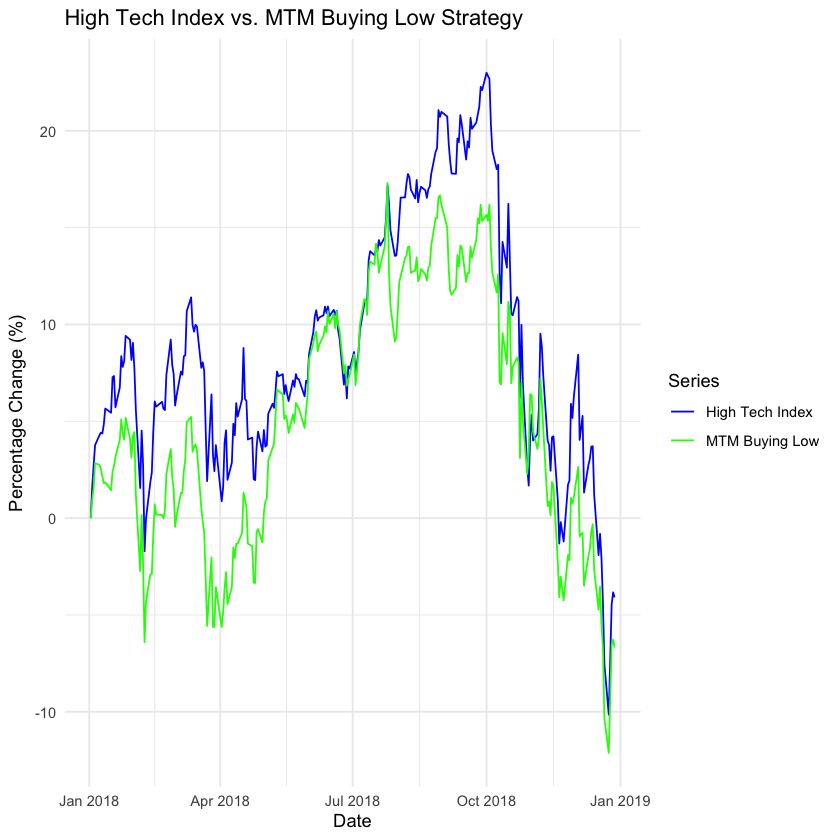

In [13]:
# Plot High Tech Index vs. MTM Buying Low
ggplot(data = plot_data_low, aes(x = Date, y = PercentageChange, color = Series)) + geom_line() + ggtitle('High Tech Index vs. MTM Buying Low Strategy') + xlab('Date') + ylab('Percentage Change (%)') + scale_color_manual(values = c('High Tech Index' = 'blue', 'MTM Buying Low' = 'green')) + theme_minimal()

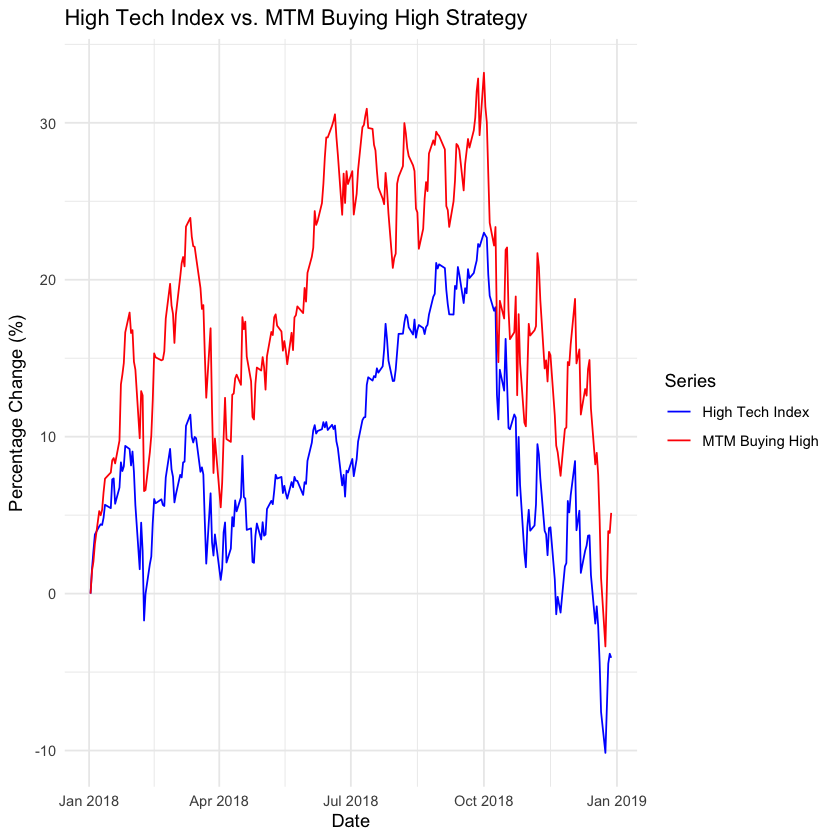

In [14]:
# Plot 2: High Tech Index vs. MTM Buying High
ggplot(data = plot_data_high, aes(x = Date, y = PercentageChange, color = Series)) + geom_line() + ggtitle('High Tech Index vs. MTM Buying High Strategy') + xlab('Date') + ylab('Percentage Change (%)') + scale_color_manual(values = c('High Tech Index' = 'blue', 'MTM Buying High' = 'red')) + theme_minimal()

### Convert mtm series from USD to JPY

,Date,Open,High,Low,Closeÿ,Adj.Closeÿ,Volume
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,2018-12-31,110.324,110.468,109.659,110.330,110.330,-
2,2018-12-28,110.860,110.930,110.222,110.855,110.855,-
3,2018-12-27,111.221,111.222,110.653,111.206,111.206,-
4,2018-12-26,110.431,110.698,110.286,110.402,110.402,-
5,2018-12-25,110.314,110.344,109.991,110.311,110.311,-
6,2018-12-24,111.100,111.140,110.267,111.054,111.054,-


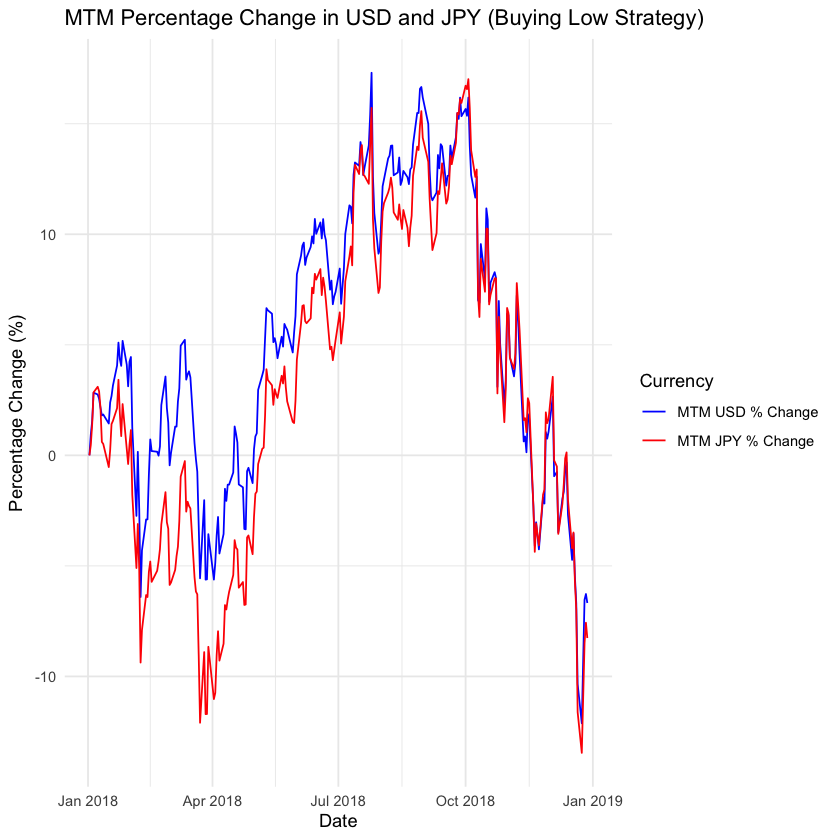

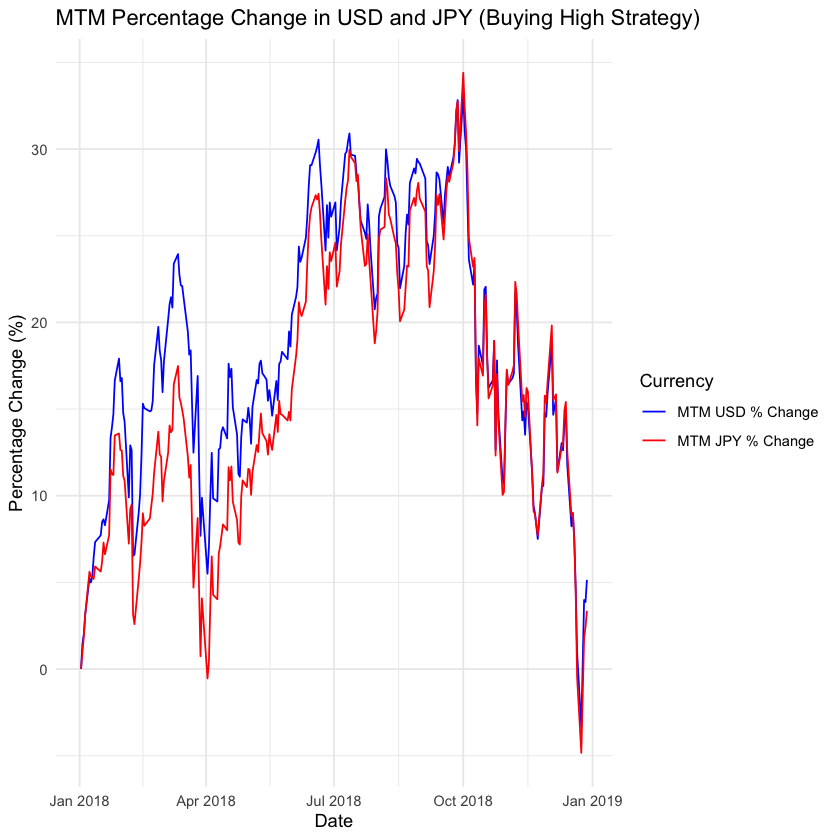

In [15]:
head(usd_jpy)

# Fix the column names in usd_jpy
colnames(usd_jpy) = iconv(colnames(usd_jpy), from = 'latin1', to = 'ASCII', sub = '')

# Buying Low strategy

# Convert MTM from USD to JPY
mtm_with_fx_low = mtm_values_low %>% left_join(usd_jpy[, c('Date', 'Close')], by = 'Date') %>% rename(ExchangeRate = Close)
mtm_with_fx_low$MTM_JPY = mtm_with_fx_low$MTM * mtm_with_fx_low$ExchangeRate

# Calculate daily percentage changes
initial_date = as.Date('2018-01-02')
initial_mtm_usd_low = mtm_with_fx_low$MTM[mtm_with_fx_low$Date == initial_date]
initial_mtm_jpy_low = mtm_with_fx_low$MTM_JPY[mtm_with_fx_low$Date == initial_date]

mtm_with_fx_low$MTM_USD_PctChange = ((mtm_with_fx_low$MTM - initial_mtm_usd_low) / initial_mtm_usd_low) * 100
mtm_with_fx_low$MTM_JPY_PctChange = ((mtm_with_fx_low$MTM_JPY - initial_mtm_jpy_low) / initial_mtm_jpy_low) * 100

# Plot curves for Buying Low strategy
plot_data_pct_low = mtm_with_fx_low[, c('Date', 'MTM_USD_PctChange', 'MTM_JPY_PctChange')]
plot_data_pct_low_melted = melt(plot_data_pct_low, id.vars = 'Date', variable.name = 'Currency', value.name = 'PercentageChange')
plot_data_pct_low_melted$Currency = factor(plot_data_pct_low_melted$Currency,levels = c('MTM_USD_PctChange', 'MTM_JPY_PctChange'),labels = c('MTM USD % Change', 'MTM JPY % Change'))

ggplot(data = plot_data_pct_low_melted, aes(x = Date, y = PercentageChange, color = Currency)) + geom_line() + ggtitle('MTM Percentage Change in USD and JPY (Buying Low Strategy)') + xlab('Date') + ylab('Percentage Change (%)') + scale_color_manual(values = c('MTM USD % Change' = 'blue', 'MTM JPY % Change' = 'red')) + theme_minimal()

# Buying High strategy

# Convert MTM from USD to JPY
mtm_with_fx_high = mtm_values_high %>% left_join(usd_jpy[, c('Date', 'Close')], by = 'Date') %>% rename(ExchangeRate = Close)
mtm_with_fx_high$MTM_JPY = mtm_with_fx_high$MTM * mtm_with_fx_high$ExchangeRate

initial_mtm_usd_high = mtm_with_fx_high$MTM[mtm_with_fx_high$Date == initial_date]
initial_mtm_jpy_high = mtm_with_fx_high$MTM_JPY[mtm_with_fx_high$Date == initial_date]

mtm_with_fx_high$MTM_USD_PctChange = ((mtm_with_fx_high$MTM - initial_mtm_usd_high) / initial_mtm_usd_high) * 100
mtm_with_fx_high$MTM_JPY_PctChange = ((mtm_with_fx_high$MTM_JPY - initial_mtm_jpy_high) / initial_mtm_jpy_high) * 100

# Plot curves for Buying High strategy
plot_data_pct_high = mtm_with_fx_high[, c('Date', 'MTM_USD_PctChange', 'MTM_JPY_PctChange')]
plot_data_pct_high_melted = melt(plot_data_pct_high, id.vars = 'Date', variable.name = 'Currency', value.name = 'PercentageChange')
plot_data_pct_high_melted$Currency = factor(plot_data_pct_high_melted$Currency, levels = c('MTM_USD_PctChange', 'MTM_JPY_PctChange'), labels = c('MTM USD % Change', 'MTM JPY % Change'))

ggplot(data = plot_data_pct_high_melted, aes(x = Date, y = PercentageChange, color = Currency)) + geom_line() + ggtitle('MTM Percentage Change in USD and JPY (Buying High Strategy)') + xlab('Date') + ylab('Percentage Change (%)') + scale_color_manual(values = c('MTM USD % Change' = 'blue', 'MTM JPY % Change' = 'red')) + theme_minimal()


### Finding optimal rebalancing window

In [16]:
run_strategy = function(universe, interval, strategy = "buy_low", initial_capital = 5000000) {
    # Initialize variables
    cash_account = 0
    portfolio = list()
    
    # Get the initial data on Jan 02, 2018
    initial_date = as.Date('2018-01-02')
    jan02_data = universe %>% filter(Date == initial_date)
    initial_allocation = initial_capital / 5
    initial_stocks = c('IBM', 'MSFT', 'GOOG', 'AAPL', 'AMZN')
    
    # Purchase initial shares on Jan 02, 2018
    for (stock in initial_stocks) {
        close_price = jan02_data[[paste0(stock, '.Close')]]
        num_shares = floor(initial_allocation / close_price)
        total_cost = num_shares * close_price
        remaining_cash = initial_allocation - total_cost
        cash_account = cash_account + remaining_cash
        portfolio[[stock]] = list(shares = num_shares)
    }
    
    # Get all trading dates from the universe 
    trading_dates = universe$Date
    start_index = which(trading_dates == initial_date)
    
    # Generate rebalancing dates based on the interval
    rebalancing_indices = seq(start_index, length(trading_dates), by = interval)
    rebalancing_dates = trading_dates[rebalancing_indices]
    rebalancing_dates = rebalancing_dates[rebalancing_dates <= as.Date('2018-12-28')]
    mtm_values = data.frame(Date = trading_dates, MTM = NA)
    
    # Main loop to implement the strategy
    for (current_date in trading_dates) {
        mtm_result = mtm_calculator(current_date, universe, portfolio, cash_account)
        mtm_values$MTM[mtm_values$Date == current_date] = mtm_result$day_mtm
        cash_account = mtm_result$cash_account  
        
        if (current_date %in% rebalancing_dates) {
            index_current = which(trading_dates == current_date)
            index_start = index_current - interval
            if (index_start < 1) {
                index_start = 1
            }
            date_start = trading_dates[index_start]
            
            # Compute percentage changes in Adj Close prices in the rebalancing window
            date_start_data = universe %>% filter(Date == date_start)
            date_end_data = universe %>% filter(Date == current_date)
            adj_close_columns = colnames(universe)[grep('.Adj.Close', colnames(universe))]
            stock_names_all = sub('.Adj.Close', '', adj_close_columns)
            stocks_df = data.frame(Stock = stock_names_all)
            stocks_df$Start_AdjClose = as.numeric(date_start_data[1, adj_close_columns])
            stocks_df$End_AdjClose = as.numeric(date_end_data[1, adj_close_columns])
            
            # Compute PercentageChange for all stocks
            stocks_df$PercentageChange = (stocks_df$End_AdjClose - stocks_df$Start_AdjClose) / stocks_df$Start_AdjClose * 100
            
            # Select stocks based on the strategy
            if (strategy == "buy_low") {
                stocks_df = stocks_df[order(stocks_df$PercentageChange), ]
            } else if (strategy == "buy_high") {
                stocks_df = stocks_df[order(stocks_df$PercentageChange, decreasing = TRUE), ]
            } else {
                stop("Invalid strategy... Choose 'buy_low' or 'buy_high'")
            }
            
            top5_stocks = head(stocks_df, 5)
            
            # Sell all current holdings
            total_cash = cash_account
            for (stock in names(portfolio)) {
                num_shares = portfolio[[stock]]$shares
                close_price = date_end_data[[paste0(stock, '.Close')]]
                cash_from_sale = num_shares * close_price
                total_cash = total_cash + cash_from_sale
            }
            
            # Reset cash account
            cash_account = 0
            
            # Buying new stocks
            allocated_cash = total_cash / 5
            for (stock in top5_stocks$Stock) {
                close_price = date_end_data[[paste0(stock, '.Close')]]
                num_shares = floor(allocated_cash / close_price)
                total_cost = num_shares * close_price
                remaining_cash = allocated_cash - total_cost
                cash_account = cash_account + remaining_cash
                portfolio[[stock]] = list(shares = num_shares)
            }
        }
    }
    
    # Extract MTM value on the last trading date before or on December 31, 2018
    last_trading_date = max(trading_dates[trading_dates <= as.Date('2018-12-28')])
    final_mtm = mtm_values$MTM[mtm_values$Date == last_trading_date]
    
    return(list(final_mtm = final_mtm, mtm_values = mtm_values))
}

# finding the optimal rebalancing interval for both strategies

intervals = 1:20 

results = data.frame(Interval = intervals, Final_MTM_Buy_Low = NA, Final_MTM_Buy_High = NA)

for (i in seq_along(intervals)) {
    interval = intervals[i]
    #buying low strategy
    result_low = run_strategy(universe, interval = interval, strategy = "buy_low")
    results$Final_MTM_Buy_Low[i] = result_low$final_mtm
    # Run buying high strategy
    result_high = run_strategy(universe, interval = interval, strategy = "buy_high")
    results$Final_MTM_Buy_High[i] = result_high$final_mtm
}

#optimal interval for buying low strategy
optimal_interval_low = results$Interval[which.max(results$Final_MTM_Buy_Low)]
max_mtm_low = max(results$Final_MTM_Buy_Low, na.rm = TRUE)

#optimal interval for buying high strategy
optimal_interval_high = results$Interval[which.max(results$Final_MTM_Buy_High)]
max_mtm_high = max(results$Final_MTM_Buy_High, na.rm = TRUE)


cat("Optimal Rebalancing Interval for Buying Low Strategy:", optimal_interval_low, "days\n")
cat("Maximum MTM on the last trading date (Buying Low):", round(max_mtm_low, 2), "\n\n")

cat("Optimal Rebalancing Interval for Buying High Strategy:", optimal_interval_high, "days\n")
cat("Maximum MTM on the last trading date (Buying High):", round(max_mtm_high, 2), "\n")

Optimal Rebalancing Interval for Buying Low Strategy: 1 days
Maximum MTM on the last trading date (Buying Low): 5024773 

Optimal Rebalancing Interval for Buying High Strategy: 1 days
Maximum MTM on the last trading date (Buying High): 5024773 
